In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from os import sys
sys.path.append("../../../machine_learning_tools/")

In [3]:
import pandas_ml as pdml
import pandas as pd

In [4]:
df = pd.read_csv("./authorship.csv")
df = df[[k for k in df.columns if k not in ["BookID"]]]
X,y = pdml.X_y(df,target_name = "Author")

In [5]:
y

0           Austen
1           Austen
2           Austen
3           Austen
4           Austen
          ...     
836    Shakespeare
837    Shakespeare
838    Shakespeare
839    Shakespeare
840    Shakespeare
Name: Author, Length: 841, dtype: object

In [6]:
labels_str = y.to_numpy()
(labels_str_unique,
 idx_to_name_map,
 labels_idx) = np.unique(labels_str,
                         return_index=True,
                         return_inverse=True)
str_order = labels_str[idx_to_name_map]
str_to_idx_map = text_to_plot_authors = {s:l_i for l_i,s in 
                        enumerate(str_order)}

# labels_colors = np.array(
#     mlu.generate_non_randon_named_color_list(
#         len(labels_str_unique))
# )
print(f"labels_str_unique = {labels_str_unique}")
# print(f"labels_colors= {labels_colors}")

str_to_idx_map

labels_str_unique = ['Austen' 'London' 'Milton' 'Shakespeare']


{'Austen': 0, 'London': 1, 'Milton': 2, 'Shakespeare': 3}

# Correlation Network

In [8]:
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt

In [55]:
sns.heatmap?

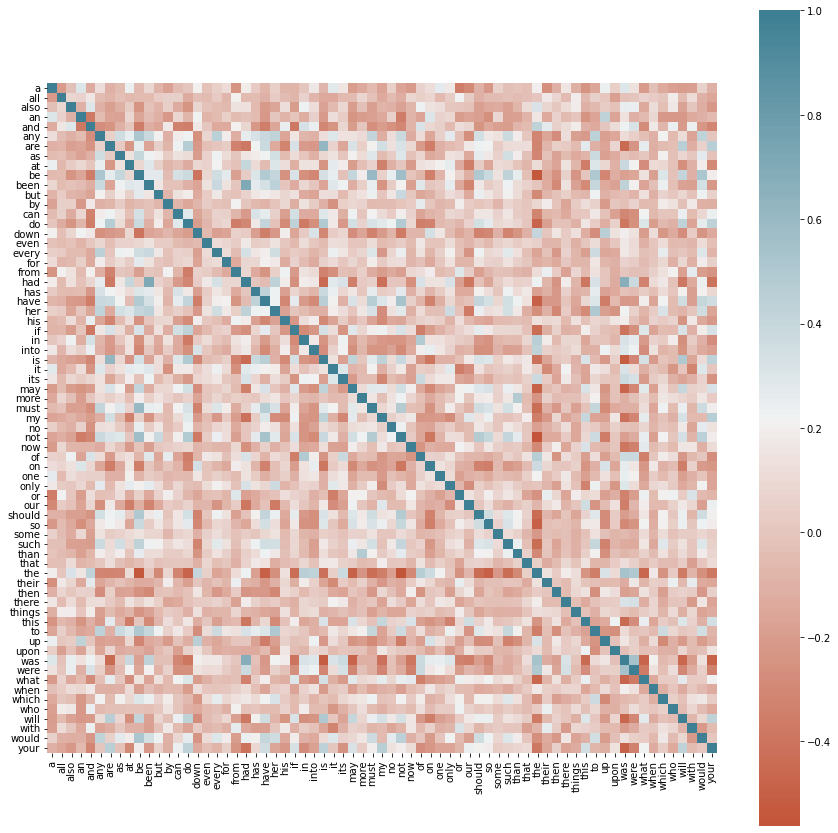

In [63]:
def heatmap_pretty(
    df,
    figure_width = 15,
    figure_height = 15,
    vmin=None,
    vmax=None,
    center = None,
    norm=None,
    cmap = sns.diverging_palette(20, 220, n=200)):

    fig, ax = plt.subplots(figsize=(figure_width, 
                                     figure_height))

    ax = sns.heatmap(
        df, 
        vmin=vmin, vmax=vmax, center=center,
        cmap=cmap,
        square=True,
        ax = ax,
        norm=norm,
        xticklabels=True,
        yticklabels=True
    )

#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     );
    
df_corr = X.corr()
heatmap_pretty(df_corr,vmin=-1, vmax=1, center=0,)

In [64]:
import numpy as np
from matplotlib import pyplot as plt
import numpy_ml as nu
def block_modeling_correlation_ordering(corr,
                                       n_clusters = 5,
                                        plot_initial_C = False,
                                        plot_best_C = False,
                                       verbose = False):
    """
    Will rearrange rows and columns to give 
    a more clustered correlation matrix 
    
    Reference: 
    # reference: https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
    """


    # # This generates 100 variables that could possibly be assigned to 5 clusters
    # n_variables = 100
    # n_clusters = 5
    # n_samples = 1000

    # # To keep this example simple, each cluster will have a fixed size
    # cluster_size = n_variables // n_clusters

    # # Assign each variable to a cluster
    # belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
    # np.random.shuffle(belongs_to_cluster)

    # # This latent data is used to make variables that belong
    # # to the same cluster correlated.
    # latent = np.random.randn(n_clusters, n_samples)

    # variables = []
    # for i in range(n_variables):
    #     variables.append(
    #         np.random.randn(n_samples) + latent[belongs_to_cluster[i], :]
    #     )

    # variables = np.array(variables)

    # C = np.cov(variables)

    if not nu.is_array_like(corr):
        C = corr.to_numpy()
    else:
        C = corr
    n_variables = len(corr)
    cluster_size = n_variables//n_clusters

    def score(C):
        '''
        Function to assign a score to an ordered covariance matrix.
        High correlations within a cluster improve the score.
        High correlations between clusters decease the score.
        '''
        score = 0
        for cluster in range(n_clusters):
            inside_cluster = np.arange(cluster_size) + cluster * cluster_size
            outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

            # Belonging to the same cluster
            score += np.sum(C[inside_cluster, :][:, inside_cluster])

            # Belonging to different clusters
            score -= np.sum(C[inside_cluster, :][:, outside_cluster])
            score -= np.sum(C[outside_cluster, :][:, inside_cluster])

        return score



    initial_C = C
    initial_score = score(C)
    initial_ordering = np.arange(n_variables)

    if plot_initial_C: 
        plt.figure()
        plt.imshow(C, interpolation='nearest')
        plt.title('Initial C')
        print('Initial ordering:', initial_ordering)
        print('Initial covariance matrix score:', initial_score)

    # Pretty dumb greedy optimization algorithm that continuously
    # swaps rows to improve the score
    def swap_rows(C, var1, var2):
        '''
        Function to swap two rows in a covariance matrix,
        updating the appropriate columns as well.
        '''
        D = C.copy()
        D[var2, :] = C[var1, :]
        D[var1, :] = C[var2, :]

        E = D.copy()
        E[:, var2] = D[:, var1]
        E[:, var1] = D[:, var2]

        return E

    current_C = C
    current_ordering = initial_ordering
    current_score = initial_score

    max_iter = 1000
    for i in range(max_iter):
        # Find the best row swap to make
        best_C = current_C
        best_ordering = current_ordering
        best_score = current_score
        for row1 in range(n_variables):
            for row2 in range(n_variables):
                if row1 == row2:
                    continue
                option_ordering = best_ordering.copy()
                option_ordering[row1] = best_ordering[row2]
                option_ordering[row2] = best_ordering[row1]
                option_C = swap_rows(best_C, row1, row2)
                option_score = score(option_C)

                if option_score > best_score:
                    best_C = option_C
                    best_ordering = option_ordering
                    best_score = option_score

        if best_score > current_score:
            # Perform the best row swap
            current_C = best_C
            current_ordering = best_ordering
            current_score = best_score
        else:
            # No row swap found that improves the solution, we're done
            break

    # Output the result
    if plot_best_C:
        plt.figure()
        plt.imshow(current_C, interpolation='nearest')
        plt.title('Best C')
    
    if verbose:
        print('Best ordering:', current_ordering)
        print('Best score:', current_score)
        print()
        print('Cluster     [variables assigned to this cluster]')
        print('------------------------------------------------')
        for cluster in range(n_clusters):
            print('Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]))
            
    return current_ordering

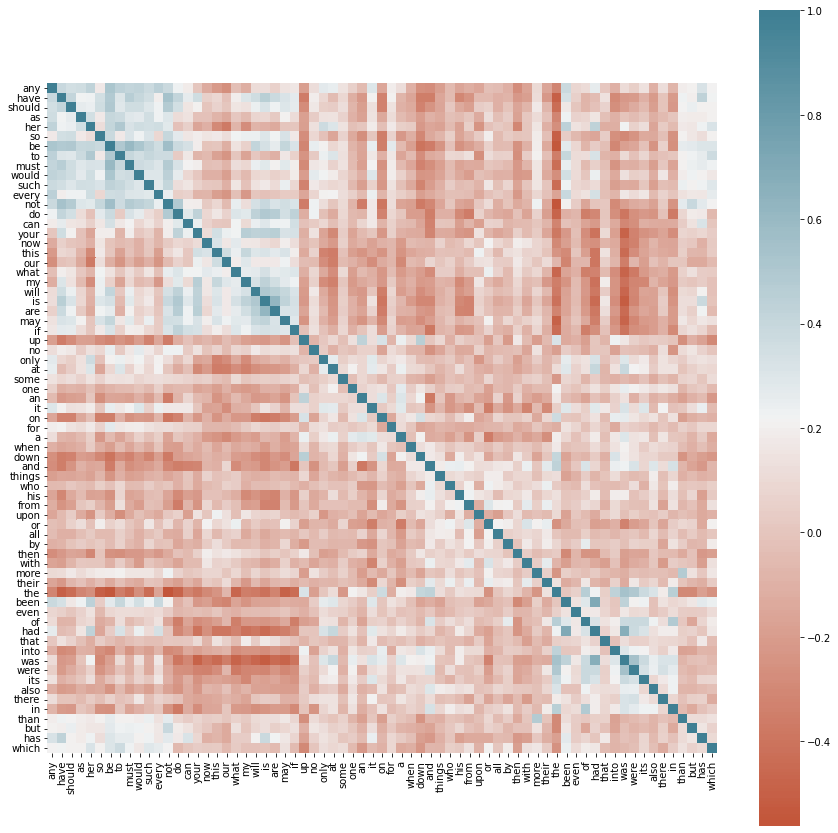

In [65]:
corr_ordering = block_modeling_correlation_ordering(df_corr,)
heatmap_pretty(df_corr.iloc[corr_ordering,corr_ordering],
              vmin=-1, vmax=1, center=0,)

# Graphical Lasso Model

In [66]:
import numpy as np
from sklearn.covariance import GraphicalLassoCV
# true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
#                      [0.0, 0.4, 0.0, 0.0],
#                      [0.2, 0.0, 0.3, 0.1],
#                      [0.0, 0.0, 0.1, 0.7]])
# np.random.seed(0)
# X = np.random.multivariate_normal(mean=[0, 0, 0, 0],
#                                   cov=true_cov,
#                                   size=200)
cov = GraphicalLassoCV().fit(X)
cov

GraphicalLassoCV()

In [67]:
print(f"picked L1 penalization parameter = {cov.alpha_}")

picked L1 penalization parameter = 2.5491866340835654


In [68]:
import pandas as pd
df_graphical = pd.DataFrame(cov.precision_)
df_graphical.index = X.columns
df_graphical.columns = X.columns
df_graphical

a       all      also        an       and       any       are  \
a      0.013749  0.003847  0.000000 -0.002029  0.000228 -0.001777  0.000000   
all    0.003847  0.059435 -0.000000 -0.002508 -0.002237  0.000000  0.000000   
also   0.000000 -0.000000  1.626004  0.000000 -0.000841  0.000000  0.000000   
an    -0.002029 -0.002508  0.000000  0.024706  0.006201  0.000000  0.000000   
and    0.000228 -0.002237 -0.000841  0.006201  0.008728  0.002043  0.000171   
...         ...       ...       ...       ...       ...       ...       ...   
who    0.001468 -0.000000 -0.000000  0.001356 -0.004021  0.000000  0.000000   
will   0.000837  0.000000  0.000000  0.001852  0.000000 -0.000000 -0.002572   
with   0.000000 -0.000000 -0.000000  0.000000 -0.002732  0.000000  0.000000   
would -0.000000  0.000000  0.000000  0.000000  0.000481 -0.000000 -0.000000   
your   0.000000  0.000031  0.000000  0.000000  0.001760  0.000000 -0.005058   

             as        at        be  ...       was      were      what  \
a     -0.000000 -0.002840 -0.000000  ... -0.000466 -0.000000  0.000872   
all    0.000000  0.000000  0.000000  ...  0.000000  0.000000 -0.000000   
also   0.000000 -0.000000  0.000000  ... -0.000000 -0.000000  0.000000   
an     0.001097 -0.000000  0.000000  ... -0.000578  0.003781  0.000000   
and   -0.000000  0.000000  0.000741  ... -0.000405 -0.000969  0.001547   
...         ...       ...       ...  ...       ...       ...       ...   
who    0.000000  0.000000 -0.000000  ...  0.000000 -0.000000 -0.000000   
will   0.000000  0.000213 -0.009717  ...  0.003083  0.000000 -0.000000   
with  -0.000000  0.000000  0.000000  ...  0.002573  0.000000  0.000000   
would -0.000000 -0.000000 -0.011326  ... -0.003383 -0.000000  0.000000   
your   0.000000  0.000897 -0.000000  ...  0.002997  0.000000  0.000000   

           when     which       who      will      with     would      your  
a      0.000000  0.000000  0.001468  0.000837  0.000000 -0.000000  0.000000  
all   -0.000000  0.000000 -0.000000  0.000000 -0.000000  0.000000  0.000031  
also  -0.000000 -0.000000 -0.000000  0.000000 -0.000000  0.000000  0.000000  
an    -0.000000  0.001604  0.001356  0.001852  0.000000  0.000000  0.000000  
and   -0.001683  0.000000 -0.004021  0.000000 -0.002732  0.000481  0.001760  
...         ...       ...       ...       ...       ...       ...       ...  
who    0.000000 -0.000000  0.160124  0.000000 -0.000000  0.000000  0.000000  
will   0.000000  0.000000  0.000000  0.058302  0.000000  0.000000 -0.004682  
with  -0.000000 -0.000000 -0.000000  0.000000  0.042040  0.000506  0.000000  
would  0.000000 -0.000000  0.000000  0.000000  0.000506  0.088807  0.000000  
your   0.000000 -0.000000  0.000000 -0.004682  0.000000  0.000000  0.044674  

[69 rows x 69 columns]

In [69]:
graph_ordering = block_modeling_correlation_ordering(df_graphical)
graph_ordering

array([18, 65, 32,  7, 41, 60, 36, 21, 17, 63, 10,  3,  5,  9, 53, 43, 54,
       52, 26, 27,  8, 14, 22, 23, 19, 49, 15, 33,  6, 59, 57, 25, 61, 31,
       55, 11, 13, 37, 38, 29, 12,  1, 42, 64,  0, 45, 46, 47, 48, 44, 50,
       51, 39, 67, 28, 30, 56, 68, 58, 20, 35, 16, 62,  2, 40, 34,  4, 24,
       66])

In [70]:
df_graphical.iloc[graph_ordering,graph_ordering]

for      will      more        as      only      were       not  \
for   0.047547 -0.000000  0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
will -0.000000  0.058302 -0.000000  0.000000  0.000000  0.000000 -0.000000   
more  0.000000 -0.000000  0.165471 -0.000000 -0.000000 -0.000000 -0.000000   
as   -0.000000  0.000000 -0.000000  0.041971 -0.000000 -0.000000 -0.000000   
only -0.000000  0.000000 -0.000000 -0.000000  0.271808 -0.000000 -0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
one  -0.000000  0.000000  0.000000  0.000000 -0.000000 -0.000000 -0.000000   
my   -0.000000 -0.000067  0.000000  0.000233  0.002091  0.001061  0.001520   
and   0.000412  0.000000 -0.000526 -0.000000  0.000000 -0.000969  0.001817   
his   0.000436  0.000955 -0.000000 -0.000000  0.000000  0.003118  0.000000   
with  0.000000  0.000000 -0.000000 -0.000000  0.000000  0.000000  0.000000   

           has    every  which  ...       had        no  even      when  \
for  -0.000000 -0.00000   -0.0  ... -0.000000 -0.000000  -0.0 -0.000000   
will -0.000000 -0.00000    0.0  ...  0.002554 -0.000000   0.0  0.000000   
more  0.000000 -0.00000   -0.0  ... -0.000000 -0.000000  -0.0  0.000000   
as   -0.000000 -0.00000   -0.0  ... -0.000332  0.000000  -0.0  0.000000   
only -0.000000 -0.00000   -0.0  ... -0.000000 -0.000000  -0.0 -0.000000   
...        ...      ...    ...  ...       ...       ...   ...       ...   
one  -0.000000 -0.00000    0.0  ... -0.000000  0.000000   0.0 -0.000000   
my    0.000000  0.00218    0.0  ...  0.000927 -0.000000   0.0  0.000000   
and   0.001123  0.00000    0.0  ...  0.000000  0.002857  -0.0 -0.001683   
his   0.000000  0.00000   -0.0  ... -0.001764  0.000227  -0.0 -0.000000   
with  0.000000  0.00000   -0.0  ...  0.000000  0.000000   0.0 -0.000000   

          also       one        my       and       his      with  
for   0.000000 -0.000000 -0.000000  0.000412  0.000436  0.000000  
will  0.000000  0.000000 -0.000067  0.000000  0.000955  0.000000  
more -0.000000  0.000000  0.000000 -0.000526 -0.000000 -0.000000  
as    0.000000  0.000000  0.000233 -0.000000 -0.000000 -0.000000  
only -0.000000 -0.000000  0.002091  0.000000  0.000000  0.000000  
...        ...       ...       ...       ...       ...       ...  
one  -0.000000  0.143701  0.001143  0.000000 -0.000000  0.000000  
my    0.000000  0.001143  0.016138  0.000000  0.002990  0.000000  
and  -0.000841  0.000000  0.000000  0.008728 -0.000478 -0.002732  
his  -0.000000 -0.000000  0.002990 -0.000478  0.013372 -0.001420  
with -0.000000  0.000000  0.000000 -0.002732 -0.001420  0.042040  

[69 rows x 69 columns]

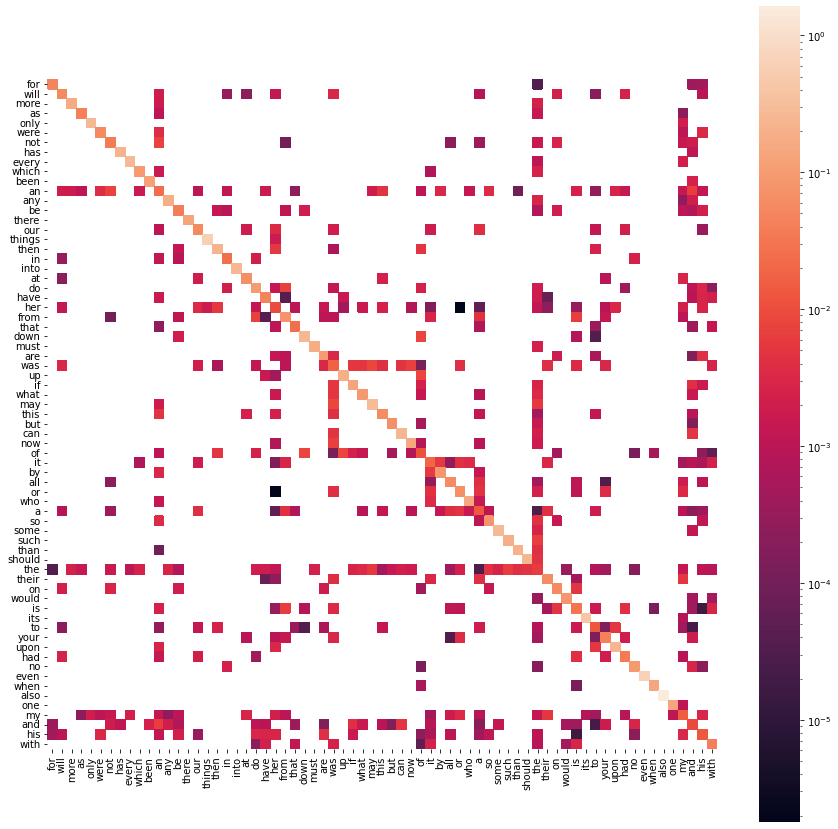

In [71]:
from matplotlib.colors import LogNorm, Normalize
heatmap_pretty(df_graphical.iloc[graph_ordering,graph_ordering],
               norm=LogNorm(),
              cmap=None)

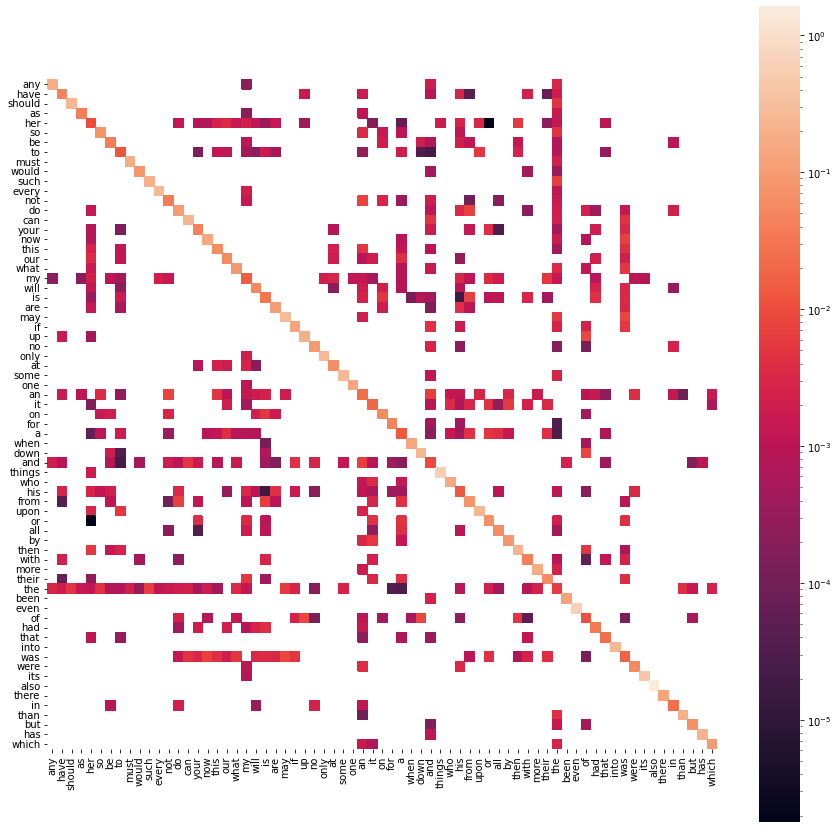

In [73]:
from matplotlib.colors import LogNorm, Normalize
heatmap_pretty(df_graphical.iloc[corr_ordering,corr_ordering],
               norm=LogNorm(),
              cmap=None)